In [61]:
import pandas as pd
from pandas import DataFrame
import datetime
import re
from sets import Set
#import pandas.io.data
import numpy as np
from itertools import izip
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#print(plt.style.available)
plt.style.use('ggplot')
import random
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import tree
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
import warnings
warnings.filterwarnings('ignore')


all_icd_for_patients = {}
all_snomed_for_patients = {}

table_names = ['all_encounter_data', 'demographics', 'encounters', 'family_hist_for_Enc',
 'family_hist_list', 'ICD_for_Enc', 'ICD_list', 'macula_findings_for_Enc',
 'SL_Lens_for_Enc', 'SNOMED_problem_list', 'systemic_disease_for_Enc', 'systemic_disease_list']

path ='C:/Users/mutre/Desktop/Math 497/ICO_data/'
dfs = [pd.read_pickle(path + name + '.pickle') if name != 'ICD_list' else None 
       for name in table_names]

systemic=dfs[10]

latest_encounter=pd.read_csv('C:/Users/mutre/Downloads/FinalDataSet.csv')
person_nbr=latest_encounter['Person_Nbr']
last_enc_number=latest_encounter['Enc_Nbr']

icd=dfs[5]


'''
for index, row in icd.iterrows():
    p_nbr = row['Person_Nbr']
    icd_code = re.sub(r'\.', '', row['Diagnosis_Code_ID'])
    all_icd_for_patients.setdefault(p_nbr, {})[icd_code]=1

for index, row in snomed_list.iterrows():
    p_nbr = row['Person_Nbr']
    snomed_code = row['Concept_ID']
    all_snomed_for_patients.setdefault(p_nbr, {})[snomed_code]=1
'''

all_person_nbr = person_nbr    
person_nbr=np.unique(icd['Person_Nbr'])

#These ICD have to be according to Diabetes Types
#vision_threatning=['362.02','E10.351','E10.359','E11.351','E11.359','E13.351','E13.359','E10.352','E10.353',' E10.354', 'E10.355','E11.352',' E11.353','E11.354','E11.355'
#                   ,'362.06','E10.341','E10.349','E11.341','E11.349','E13.341','E13.349']
#non_vision_threatning=['362.04','E10.321','E10.329','E11.321','E11.329','E13.321','E13.329','362.03'
#                       ,'362.05','E10.331','E10.339','E11.331','E11.339','E13.331','E13.339'
#                       ,'362.01','E10.311','E10.319','E11.311','E11.319','E13.311','E13.319']

non_vision_threatning='E1031*|E1032*|E1033*|E1131*|E1132*|E1133*|E1331*|E1332*|E1333*|36201|36203|36204|36205|2505*'

vision_threatning='E1034*|E1035*|E1134*|E1135*|E1334*|E1335*|36202|36206'

vision_threat_snomed=Set(['59276001' , '232021008' , '232022001' , '312905005' , '312906006' , '312907002' , '312908007' , '312909004' , '399862001' , '399863006' , '399872003' , '399873008' , '399874002' , '399876000' , '399877009' , '408413000' , '1501000119109' , '60971000119101' , '97341000119105' , '103981000119101' , '430801000124103'])
non_vision_threat_snomed=Set(['4855003' , '193349004' , '312903003' , '312904009' , '312905005' , '390834004' , '399875001' , '408311002' , '408385003' , '408409007' , '408410002' , '408412005' , '420789003' , '422034002' , '706894000' , '1551000119108' , '60961000119107' , '97331000119101' , '138911000119106' , '138921000119104'])


#PDR % Severe NPDR
all_vision_threatning=[]

# Mild and Moderate NPDR, DM_Background
all_non_vision_threatning=[]

#NO DR
target_dm_noDR=[]

for i in range(len(last_enc_number)):  
    icd_nmbrs = icd.loc[icd['Enc_Nbr']==last_enc_number[i]]['Diagnosis_Code_ID'].values
    snomed_codes = systemic.loc[systemic['Enc_Nbr']==last_enc_number[i]]['Snomed_Code'].values
    flag = False
    
    #for icds in all_icds:
    for icds in icd_nmbrs:
        icds = re.sub(r'\.', '', icds)
        if bool(re.match(vision_threatning,icds)):    
            all_vision_threatning.append(last_enc_number[i])
            latest_encounter.loc[latest_encounter['Enc_Nbr']==last_enc_number[i],'target_class']=1
            flag = True
            break
    
    if flag == False:
        #for icds in all_icds:
        for icds in icd_nmbrs:
            icds = re.sub(r'\.', '', icds)
            if bool(re.match(non_vision_threatning,icds)):
                all_non_vision_threatning.append(last_enc_number[i])
                latest_encounter.loc[latest_encounter['Enc_Nbr']==last_enc_number[i],'target_class']=2
                flag = True
                break
                  
    if flag == False:
        for snomeds in snomed_codes:
            if len(snomeds) > 0 and snomeds in vision_threat_snomed:
                all_vision_threatning.append(last_enc_number[i])
                latest_encounter.loc[latest_encounter['Enc_Nbr']==last_enc_number[i],'target_class']=1
                flag = True
                break
                
    if flag == False:           
        for snomeds in snomed_codes:
            if len(snomeds) > 0 and snomeds in non_vision_threat_snomed:
                all_non_vision_threatning.append(last_enc_number[i])
                latest_encounter.loc[latest_encounter['Enc_Nbr']==last_enc_number[i],'target_class']=2
                flag = True
                break
    
    if flag == False:
        target_dm_noDR.append(last_enc_number[i])
        latest_encounter.loc[latest_encounter['Enc_Nbr']==last_enc_number[i],'target_class']=3


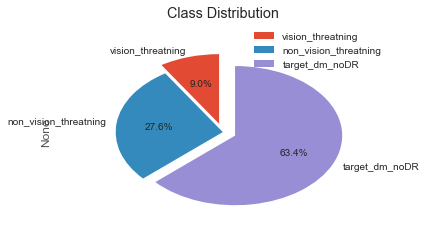

In [62]:
classes = [all_vision_threatning,all_non_vision_threatning,target_dm_noDR]
classes_name = ['vision_threatning','non_vision_threatning','target_dm_noDR']
classes_dict = {}
for x in range(len(classes)):
    name = classes_name[x]
    freq = len(classes[x])
    classes_dict[name]= freq
s = pd.Series(data=classes_dict.values(),
index = classes_dict.keys())
ax = s.plot.pie(autopct='%1.1f%%',startangle=90,explode=(0.1,0,0.1), radius = 0.8)
ax.set_title('Class Distribution')
ax.legend()

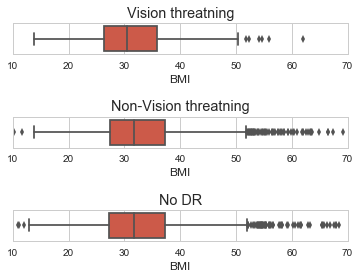

In [63]:
plt.subplots_adjust(hspace=2)
sns.set_style("whitegrid")
plt.subplot(311)
bmi1 = latest_encounter.BMI[latest_encounter.target_class == 1]
BMI1 = sns.boxplot(bmi1)
BMI1.set(xlim=(10, 70))
BMI1.set_title('Vision threatning')
plt.subplot(312)
bmi2 = latest_encounter.BMI[latest_encounter.target_class == 2]
BMI2 = sns.boxplot(bmi2)
BMI2.set(xlim=(10, 70))
BMI2.set_title('Non-Vision threatning')
plt.subplot(313)
bmi3 = latest_encounter.BMI[latest_encounter.target_class == 3]
BMI3 = sns.boxplot(bmi3)
BMI3.set(xlim=(10, 70))
BMI3.set_title('No DR')


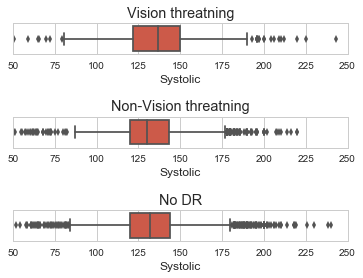

In [64]:
plt.subplots_adjust(hspace=2)
sns.set_style("whitegrid")
plt.subplot(311)
bpu1 = latest_encounter.BP_Upper[latest_encounter.target_class == 1]
BPU1 = sns.boxplot(bpu1)
BPU1.set(xlim=(50, 250))
BPU1.set_title('Vision threatning')
BPU1.set_xlabel('Systolic')
plt.subplot(312)
bpu2 = latest_encounter.BP_Upper[latest_encounter.target_class == 2]
BPU2 = sns.boxplot(bpu2)
BPU2.set(xlim=(50, 250))
BPU2.set_title('Non-Vision threatning')
BPU2.set_xlabel('Systolic')
plt.subplot(313)
bpu3 = latest_encounter.BP_Upper[latest_encounter.target_class == 3]
BPU3 = sns.boxplot(bpu3)
BPU3.set(xlim=(50, 250))
BPU3.set_title('No DR')
BPU3.set_xlabel('Systolic')

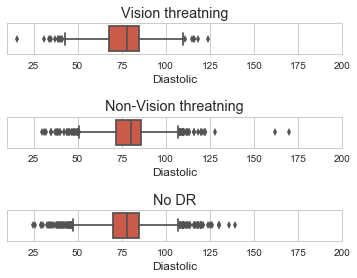

In [65]:
plt.subplots_adjust(hspace=2)
sns.set_style("whitegrid")
plt.subplot(311)
bpl1 = latest_encounter.BP_Lower[latest_encounter.target_class == 1]
BPL1 = sns.boxplot(bpl1)
BPL1.set(xlim=(10, 200))
BPL1.set_title('Vision threatning')
BPL1.set_xlabel('Diastolic')
plt.subplot(312)
bpl2 = latest_encounter.BP_Lower[latest_encounter.target_class == 2]
BPL2 = sns.boxplot(bpl2)
BPL2.set(xlim=(10, 200))
BPL2.set_title('Non-Vision threatning')
BPL2.set_xlabel('Diastolic')
plt.subplot(313)
bpl3 = latest_encounter.BP_Lower[latest_encounter.target_class == 3]
BPL3 = sns.boxplot(bpl3)
BPL3.set(xlim=(10, 200))
# BPU3.set(xlim=(10, 70))
BPL3.set_title('No DR')
BPL3.set_xlabel('Diastolic')

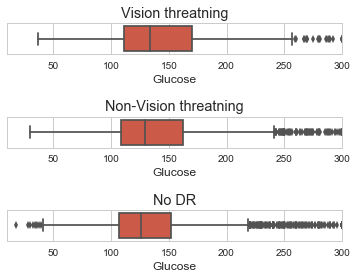

In [66]:
plt.subplots_adjust(hspace=2)
sns.set_style("whitegrid")
plt.subplot(311)
glu1 = latest_encounter.Glucose[latest_encounter.target_class == 1]
GLU1 = sns.boxplot(glu1)
GLU1.set(xlim=(10, 300))
GLU1.set_title('Vision threatning')
plt.subplot(312)
glu2 = latest_encounter.Glucose[latest_encounter.target_class == 2]
GLU2 = sns.boxplot(glu2)
GLU2.set(xlim=(10, 300))
GLU2.set_title('Non-Vision threatning')
plt.subplot(313)
glu3 = latest_encounter.Glucose[latest_encounter.target_class == 3]
GLU3 = sns.boxplot(glu3)
GLU3.set(xlim=(10, 300))
# BPU3.set(xlim=(10, 70))
GLU3.set_title('No DR')

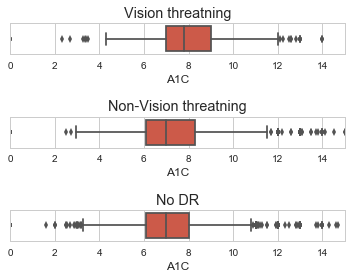

In [67]:
plt.subplots_adjust(hspace=2)
sns.set_style("whitegrid")
plt.subplot(311)
a1c1 = latest_encounter.A1C[latest_encounter.target_class == 1]
A1C1 = sns.boxplot(a1c1)
A1C1.set(xlim=(0, 15))
A1C1.set_title('Vision threatning')
plt.subplot(312)
a1c2 = latest_encounter.A1C[latest_encounter.target_class == 2]
A1C2 = sns.boxplot(a1c2)
A1C2.set(xlim=(0, 15))
A1C2.set_title('Non-Vision threatning')
plt.subplot(313)
a1c3 = latest_encounter.A1C[latest_encounter.target_class == 3]
A1C3 = sns.boxplot(a1c3)
A1C3.set(xlim=(0, 15))
# BPU3.set(xlim=(10, 70))
A1C3.set_title('No DR')

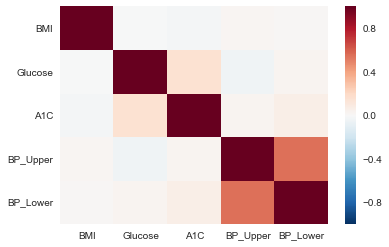

In [74]:
corr = latest_encounter.iloc[:,[9,10,11,12,13,14]].corr()
sns.heatmap(corr)

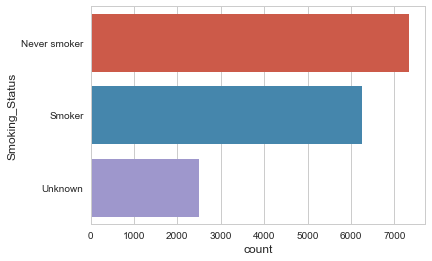

In [69]:
latest_encounter.replace(to_replace='Never Smoker',value='Never smoker',inplace=True,axis='Smoking_Status')
smoking_status = sns.countplot(y="Smoking_Status", data=latest_encounter,orient="v")

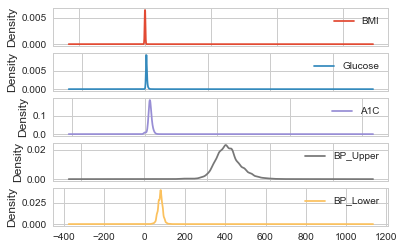

In [75]:
# latest_encounter.hist()
plt.subplots_adjust(hspace=2)
x = latest_encounter.iloc[:,[9,10,11,12,13,14]].plot(kind='density', subplots=True, sharex=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001AE12CF8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000015DFBCC0>]], dtype=object)

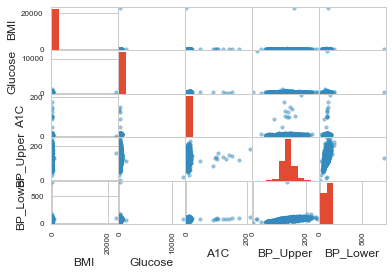

In [76]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(latest_encounter.iloc[:,[9,10,11,12,13,14]])

In [77]:
cols =[latest_encounter.BMI.dropna(),latest_encounter.Glucose.dropna(),latest_encounter.A1C.dropna(),latest_encounter.BP_Lower.dropna(),latest_encounter.BP_Upper.dropna()]
High = []
Low = []
from scipy.stats import iqr
for i in cols:
    Q1 = np.percentile(i,5)
    Q3 = np.percentile(i,95)
    High.append(Q3 + 1.5*iqr(i))
    Low.append(Q1 - 1.5*iqr(i))
    print i.name,"\n",Q1,Q3,"\n",Low,High
print Low,"\n" ,High
temp_latest_encounter=latest_encounter
latest_encounter.loc[temp_latest_encounter['BMI']<Low[0],'BMI']=Low[0]
latest_encounter.loc[temp_latest_encounter['BMI']>High[0],'BMI']=High[0]

latest_encounter.loc[temp_latest_encounter['Glucose']<Low[1],'Glucose']=Low[1]
latest_encounter.loc[temp_latest_encounter['Glucose']>High[1],'Glucose']=High[1]

latest_encounter.loc[temp_latest_encounter['A1C']<Low[2],'A1C']=Low[2]
latest_encounter.loc[temp_latest_encounter['A1C']>High[2],'A1C']=High[2]

latest_encounter.loc[temp_latest_encounter['BP_Upper']<Low[3],'BP_Upper']=Low[3]
latest_encounter.loc[temp_latest_encounter['BP_Upper']>High[3],'BP_Upper']=High[3]

latest_encounter.loc[temp_latest_encounter['BP_Lower']<Low[4],'BP_Lower']=Low[4]
latest_encounter.loc[temp_latest_encounter['BP_Lower']>High[4],'BP_Lower']=High[4]

BMI 
21.9865 48.06 
[7.2865000000000038] [62.759999999999998]
Glucose 
80.0 238.0 
[7.2865000000000038, 3.5] [62.759999999999998, 314.5]
A1C 
4.0 11.0 
[7.2865000000000038, 3.5, 1.3000000000000003] [62.759999999999998, 314.5, 13.699999999999999]
BP_Lower 
59.0 98.0 
[7.2865000000000038, 3.5, 1.3000000000000003, 36.5] [62.759999999999998, 314.5, 13.699999999999999, 120.5]
BP_Upper 
104.0 170.0 
[7.2865000000000038, 3.5, 1.3000000000000003, 36.5, 68.0] [62.759999999999998, 314.5, 13.699999999999999, 120.5, 206.0]
[7.2865000000000038, 3.5, 1.3000000000000003, 36.5, 68.0] 
[62.759999999999998, 314.5, 13.699999999999999, 120.5, 206.0]


In [78]:
colnames=list(latest_encounter)
for name in colnames:
    latest_encounter[name][latest_encounter[name].isnull()]=0

In [79]:
latest_encounter.columns
# len(latest_encounter.Person_Nbr.unique())

Index([u'Unnamed: 0', u'Column', u'Enc_ID', u'Enc_Nbr', u'Enc_Date',
       u'Person_ID', u'Person_Nbr', u'Primary_Payer', u'Smoking_Status',
       u'BMI', u'BP', u'Glucose', u'A1C', u'BP_Upper', u'BP_Lower',
       u'African American_race', u'American Indian or Alaska Native', u'Asian',
       u'Declined to specify_race', u'Greek', u'Hawaiian',
       u'Hispanic Or Latino', u'Multi-racial',
       u'Other Pacific Islander (Not Hawaiian)', u'Other Race', u'White',
       u'African American_ethnicity', u'Declined to specify_ethnicity',
       u'Hispanic or Latino', u'Not Hispanic or Latino', u'Aunt', u'Children',
       u'Father', u'Maternal grandfather', u'Maternal grandmother', u'Mother',
       u'Other_relations', u'Paternal grandfather', u'Paternal grandmother',
       u'Siblings', u'Uncle', u'Never Smoker', u'Smoker',
       u'Unknown_smoking_status', u'Age', u'target_class'],
      dtype='object')

In [80]:
dr_data=pd.DataFrame(latest_encounter.iloc[:,9:48])
#dr_data = pd.DataFrame(latest_encounter.iloc[:,[8,10,11,42,43,44,45,46,47,48,49]])
dr_data.drop('BP',inplace=True,axis=1)
print(dr_data.shape)
dr_data.head()
len(list(dr_data))

(16087, 36)


36

In [81]:
#descriptions
print(dr_data.describe())

                BMI       Glucose           A1C      BP_Upper      BP_Lower  \
count  16087.000000  16087.000000  16087.000000  16087.000000  16087.000000   
mean      10.662745     70.216114      1.758630     79.374763     53.520348   
std       16.040521     77.458538      3.293766     55.548535     38.137229   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000     56.000000      0.000000    120.000000     70.000000   
75%       26.950000    129.000000      0.000000    120.500000     82.000000   
max       62.760000    314.500000     13.700000    120.500000    206.000000   

       African American_race  American Indian or Alaska Native         Asian  \
count           16087.000000                      16087.000000  16087.000000   
mean                0.609809                          0.003295      0.011189   
std                 0.487808                    

In [82]:
# Class Distribution
# 1 = Vision Threatening
# 2 = Non Vision Threatening
# 3 = No DR

print(dr_data.groupby('target_class').size())

target_class
1.0     1453
2.0     4441
3.0    10193
dtype: int64


In [83]:
from imblearn.over_sampling import RandomOverSampler 
from collections import Counter
array = dr_data.values
X = array[:,0:34]
Y = array[:,35]
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)
print len(X_train),len(Y_train)
print X_train.shape,Y_train.shape,X_validation.shape,Y_validation.shape

12869 12869
(12869L, 34L) (12869L,) (3218L, 34L) (3218L,)


In [84]:
from sklearn.dummy import DummyClassifier
base_clf = DummyClassifier(strategy='most_frequent',random_state=0)
dt = base_clf.fit(X_train, Y_train)
predictions = base_clf.predict(X_validation)
print("Accuracy Score on Test Data :")
print(accuracy_score(Y_validation, predictions))
print("Confusion Matrix:")
print(confusion_matrix(Y_validation, predictions))
print("Classification Report:")
print(classification_report(Y_validation, predictions))
base_clf = DummyClassifier(strategy='stratified',random_state=0)
dt = base_clf.fit(X_train, Y_train)
predictions = base_clf.predict(X_validation)
print("Accuracy Score on Test Data :")
print(accuracy_score(Y_validation, predictions))
print("Confusion Matrix:")
print(confusion_matrix(Y_validation, predictions))
print("Classification Report:")
print(classification_report(Y_validation, predictions))

Accuracy Score on Test Data :
0.652579241765
Confusion Matrix:
[[   0    0  282]
 [   0    0  836]
 [   0    0 2100]]
Classification Report:
             precision    recall  f1-score   support

        1.0       0.00      0.00      0.00       282
        2.0       0.00      0.00      0.00       836
        3.0       0.65      1.00      0.79      2100

avg / total       0.43      0.65      0.52      3218

Accuracy Score on Test Data :
0.494717215662
Confusion Matrix:
[[  27   79  176]
 [  68  239  529]
 [ 200  574 1326]]
Classification Report:
             precision    recall  f1-score   support

        1.0       0.09      0.10      0.09       282
        2.0       0.27      0.29      0.28       836
        3.0       0.65      0.63      0.64      2100

avg / total       0.50      0.49      0.50      3218



All Features
['BMI', 'Glucose', 'A1C', 'BP_Upper', 'BP_Lower', 'African American_race', 'American Indian or Alaska Native', 'Asian', 'Declined to specify_race', 'Greek', 'Hawaiian', 'Hispanic Or Latino', 'Multi-racial', 'Other Pacific Islander (Not Hawaiian)', 'Other Race', 'White', 'African American_ethnicity', 'Declined to specify_ethnicity', 'Hispanic or Latino', 'Not Hispanic or Latino', 'Aunt', 'Children', 'Father', 'Maternal grandfather', 'Maternal grandmother', 'Mother', 'Other_relations', 'Paternal grandfather', 'Paternal grandmother', 'Siblings', 'Uncle', 'Never Smoker', 'Smoker', 'Unknown_smoking_status', 'Age']


Feature ranking:
1. feature 1 | (Glucose) | (0.226978)
2. feature 4 | (BP_Lower) | (0.212800)
3. feature 0 | (BMI) | (0.172354)
4. feature 3 | (BP_Upper) | (0.127299)
5. feature 2 | (A1C) | (0.088489)
6. feature 22 | (Father) | (0.045363)
7. feature 25 | (Mother) | (0.030846)
8. feature 33 | (Unknown_smoking_status) | (0.011703)
9. feature 31 | (Never Smoker) | (0.0

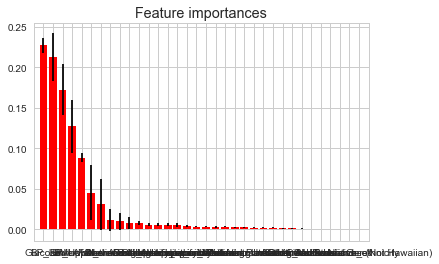

In [86]:
# Feature importances ranking with forests of trees

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, Y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

features = list(dr_data)
features = features[:-1]
print "All Features"
print features
print "\n"
# Print the feature ranking
print("Feature ranking:")
rankedFeatures = []
for f in range(X.shape[1]):
    print("%d. feature %d | (%s) | (%f)" % (f + 1, indices[f],features[indices[f]], importances[indices[f]]))
    rankedFeatures.append(features[indices[f]])

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), rankedFeatures)
plt.xlim([-1, X.shape[1]])
plt.show()

In [85]:
scoring = 'accuracy'
# 6 Algorithms need to be checked to test most suitable accurate model
models = []
models.append(('Logistic Regression', LogisticRegression()))
# models.append(('Linear Discriminant Analysis', LinearDiscriminantAnalysis()))
# models.append(('K Nearest Neighbours', KNeighborsClassifier()))
models.append(('Decision Tree Classifier', DecisionTreeClassifier()))
models.append(('Support Vector Machine', SVC()))

# evaluate each model in turn
results = []
names = []

#Features are weighted
# weight_mat = np.array([[9,0,0,0,0],[0,5,0,0,0],[0,0,20,0,0],[0,0,0,1,0],[0,0,0,0,2]])

# X_train_weighted = np.matmul(X_train ,weight_mat)

sample_wt = np.array([5 if target_class == 1 else 1 for target_class in Y_train])

clf = RandomForestClassifier(n_estimators=100, max_depth=None,min_samples_split=2, random_state=0)
kfold = model_selection.KFold(n_splits=10, random_state=seed)
scores = model_selection.cross_val_score(clf, X_train, Y_train, cv=kfold, scoring=scoring)

print "****Cross Validation Phase for ( Random Forest Classifier ) ********"
print "Cross Validation Accuracy Score mean = %f " % (scores.mean())
print "Cross Validation Accuracy Score Standard Deviation = %f " % (scores.std())

#dt = clf.fit(X_train, Y_train)
#Fitting Model
dt = clf.fit(X_train, Y_train, sample_weight=sample_wt)
predictions = clf.predict(X_validation)

print "**** Prediction metrics on Test Set for ( Random Forest Classifier )*****"
print("Accuracy Score on Test Data :")
print(accuracy_score(Y_validation, predictions))
print("Confusion Matrix:")
print(confusion_matrix(Y_validation, predictions))
print("Classification Report:")
print(classification_report(Y_validation, predictions))
# title = "Learning Curves"
# print "**** Learning Curve for ( Random Forest Classifier ) ********"
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
# plot_learning_curve(clf, title, X, Y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
# plt.show()   

for name, model in models:
    
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print "****Cross Validation Phase for ( %s ) ********" % (name)
    print "Cross Validation Accuracy Score mean = %f " % (cv_results.mean())
    print "Cross Validation Accuracy Score Standard Deviation = %f " % (cv_results.std())
    
    nb = model
#     dt = nb.fit(X_train, Y_train)
    dt = nb.fit(X_train, Y_train, sample_wt)
    predictions = nb.predict(X_validation)
    print "**** Prediction metrics on Test Set for ( %s )*****" % (name)
    print("Accuracy Score on Test Data :")
    print(accuracy_score(Y_validation, predictions))
    print("Confusion Matrix:")
    print(confusion_matrix(Y_validation, predictions))
    print("Classification Report:")
    print(classification_report(Y_validation, predictions))
#     title = "Learning Curves"
#     print "**** Learning Curve for ( %s ) ********" % (name)
#     cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
#     plot_learning_curve(model, title, X, Y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
#     plt.show()

****Cross Validation Phase for ( Random Forest Classifier ) ********
Cross Validation Accuracy Score mean = 0.660034 
Cross Validation Accuracy Score Standard Deviation = 0.014835 
**** Prediction metrics on Test Set for ( Random Forest Classifier )*****
Accuracy Score on Test Data :
0.66656308266
Confusion Matrix:
[[  16   61  205]
 [  27  418  391]
 [  88  301 1711]]
Classification Report:
             precision    recall  f1-score   support

        1.0       0.12      0.06      0.08       282
        2.0       0.54      0.50      0.52       836
        3.0       0.74      0.81      0.78      2100

avg / total       0.63      0.67      0.65      3218

****Cross Validation Phase for ( Logistic Regression ) ********
Cross Validation Accuracy Score mean = 0.704482 
Cross Validation Accuracy Score Standard Deviation = 0.015135 
**** Prediction metrics on Test Set for ( Logistic Regression )*****
Accuracy Score on Test Data :
0.595711622126
Confusion Matrix:
[[ 136   35  111]
 [ 160  422

****Cross Validation Phase for ( Naive Bayes ) ********
Cross Validation Accuracy Score mean = 0.218432 
Cross Validation Accuracy Score Standard Deviation = 0.063806 
**** Prediction metrics on Test Set for ( Naive Bayes )*****
Accuracy Score on Test Data :
0.117775015538
Confusion Matrix:
[[ 267    8    7]
 [ 770   59    7]
 [2002   45   53]]
Classification Report:
             precision    recall  f1-score   support

        1.0       0.09      0.95      0.16       282
        2.0       0.53      0.07      0.12       836
        3.0       0.79      0.03      0.05      2100

avg / total       0.66      0.12      0.08      3218

**** Learning Curve for ( Naive Bayes ) ********


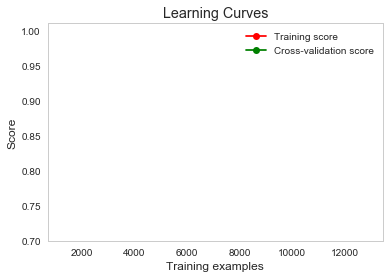

In [87]:
# Naive Bayes Classification with feature weighting method
#BMI , Glucose , A1C , Systolic , Distolic
# weight_mat = np.array([[9,0,0,0,0],[0,5,0,0,0],[0,0,20,0,0],[0,0,0,1,0],[0,0,0,0,2]])
model = GaussianNB()

#Features are weighted
# X_train_weighted = np.matmul(X_train ,weight_mat)

sample_wt = np.array([5 if target_class == 1 else 1 for target_class in Y_train])

#Fit the model
#model.fit(X_train_weighted, Y_train,sample_wt)
print "****Cross Validation Phase for ( Naive Bayes ) ********"
    
kfold = model_selection.KFold(n_splits=10, random_state=seed)
cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)

print "Cross Validation Accuracy Score mean = %f " % (cv_results.mean())
print "Cross Validation Accuracy Score Standard Deviation = %f " % (cv_results.std())

#Fitting Model
model.fit(X_train, Y_train, sample_wt)

#summarization of Naive Bayes
#Features are weighted
#X_validation_weighted = np.matmul(X_validation ,weight_mat)
#predictions = model.predict(X_validation_weighted)

predictions = model.predict(X_validation)
print "**** Prediction metrics on Test Set for ( Naive Bayes )*****"
print("Accuracy Score on Test Data :")
print(accuracy_score(Y_validation, predictions))
print("Confusion Matrix:")
print(confusion_matrix(Y_validation, predictions))
print("Classification Report:")
print(classification_report(Y_validation, predictions))
title = "Learning Curves"
print "**** Learning Curve for ( Naive Bayes ) ********"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(model, title, X, Y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
plt.show()

In [ ]:
#Decision Tree Classifier seems to have highest score among all 6 models
#Hence Decision Tree Classifier is the best model to fit into this dataset

In [ ]:
# Make predictions on validation dataset
nb = DecisionTreeClassifier()
dt = nb.fit(X_train, Y_train)

features = list(dr_data)
features = features[:-1]
#print features
classes = dt.classes_
#print classes
#Tree stored into dr.dot
tree.export_graphviz(dt, out_file='dr.dot', feature_names=features)

#%dot -Tpng dt.dot -o dt.png 
predictions = nb.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))